In [3]:
import pandas as pd
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from math import log10

In [4]:
def layout(df):
    edges = df.stack().reset_index()
    edges.columns = ['n1','n2','correlation']
    edges = edges.loc[edges['n1'] != edges['n2']].copy()

    Gx = nx.from_pandas_edgelist(edges, 'n1', 'n2', edge_attr=['correlation'])

    #ncol = len(df_p.columns)
    #threshold = 0.05/(ncol*(ncol-1)/2)##bonferroni cutoff
    threshold = 0.05
    remove = []
    for n1, n2 in Gx.edges():
        corr = Gx[n1][n2]['correlation']
        if abs(corr) > threshold:
            remove.append((n1, n2))

    Gx.remove_edges_from(remove)
    return Gx

In [5]:
def get_tsne_pos(df):
    tsne = TSNE(perplexity = 20)
    X_embedded = tsne.fit_transform(df)
    pos_dic = {}
    for i,c in enumerate(df.index):
        pos_dic[c]=X_embedded[i]
    return pos_dic

In [6]:
def color_size(df,y):
    size = {}
    color = {}
    log_colors = {}
    for x in df.columns:
        cor = stats.spearmanr(df[x].values.tolist(), y.values.tolist())
        #print(x, cor)
        size[x] = cor[0]
        color[x] = cor[1]
        try:
            l = -log10(cor[1])
            log_colors[x] = l
        except:
            print('Error',cor[1])
            log_colors[x] = 0
    return size, color, log_colors

In [7]:
def plot_network(Gx, colors, sizes, positions):
    cscale = 1
    sscale = 100
    node_color_=[c*cscale for c in colors]
    node_size_=[abs(c)*sscale for c in sizes]
    vmin = min(node_color_)
    vmax = max(node_color_)

    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap = mpl.cm.autumn)
    sm.set_array([])
    nx.draw(Gx, pos=positions, with_labels=False, node_size=node_size_,
             node_color=node_color_, edge_color='black', width = 0.001,cmap = mpl.cm.autumn, vmin=vmin, vmax=vmax)
    plt.title("correlation network ")

    cbar = plt.colorbar(sm, ticks=range(4))
    #plt.savefig('complete_net_log_facit.pdf', bbox_inches="tight")
    #plt.savefig('complete_net_log_facit.png', bbox_inches="tight")

In [8]:
def get_corr(df):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = stats.spearmanr(df[x], df[y])
            #r, p, lo, hi = pearsonr_ci (df[x].values, df[y].values)
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

In [9]:
def match_data(df1, df2, target):
    df1 = df1.dropna(axis=1)
    df2 = df2.dropna(subset=[target], axis=0)
    
    set1 = set(df1['pid'].values.tolist())
    set2 = set(df2['pid'].values.tolist())
    intersection = set1.intersection(set2)
    df1 = df1[df1['pid'].isin(intersection)]
    df2 = df2[df2['pid'].isin(intersection)]
    df1 = df1.set_index('pid')
    df1 = df1.reindex(df2['pid'].values.tolist())
    df1 = df1.reset_index()
    return df1, df2

# Read data

In [10]:
f1 = '4manuscript/cleaned_NPX_data.csv'
f2 = '4manuscript/cleaned_patient_data.csv'
df1 =  pd.read_csv(f1)
df2 = pd.read_csv(f2)
target = 'facit'

# Match data

In [11]:
df1, df2 = match_data(df1, df2, target)
net_df = df1.drop('pid', axis=1)
y = df2[target]

# Generate network info

In [ ]:
df_corr, df_p = get_corr(net_df)
G = layout(df_p)
pos= nx.random_layout(G)
size, color, log_colors = color_size(net_df,y)
pos = get_tsne_pos(net_df.transpose())

# Plot network

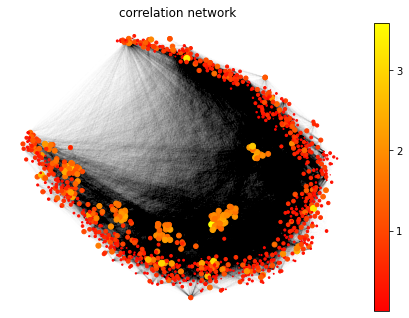

In [114]:
plot_network(G, log_colors.values(), size.values(), pos)
# SIS3

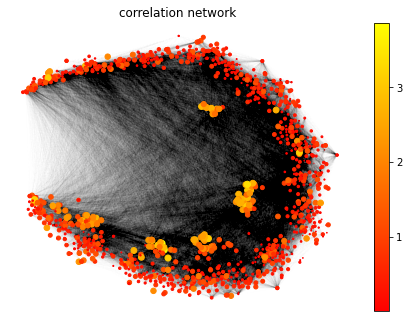

In [124]:
plot_network(G, log_colors.values(), size.values(), pos)
# FACIT